# "SpreadSheet Munging Strategies in Python - Pivot Tables - Complex Unpivoting"
> "Extract data from Complex Pivot tables in a spreadsheet"

- toc: true
- branch: master
- badges: true
- hide_binder_badge: True
- hide_colab_badge: True
- comments: true
- author: Samuel Oranyeli
- categories: [Spreadsheet, python, Pandas]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

## __Pivot Tables - Complex Unpivoting__

*updated : April 15, 2022*

This is part of a series of blog posts about extracting data from spreadsheets using Python.  It is based on the [book](https://nacnudus.github.io/spreadsheet-munging-strategies/index.html) written by [Duncan Garmonsway](https://twitter.com/nacnudus?lang=en), which was written primarily for R users. LInks to the other posts are on the [homepage](https://samukweku.github.io/data-wrangling-blog/).

We've dealt with pivot tables in one of the [previous posts](https://samukweku.github.io/data-wrangling-blog/fastpages/jupyter/excel/spreadsheet/python/pandas/2020/05/10/Pivot-Tables-Simple-Unpivoting.html). Here, we take the complexity up a notch. Let's dive in to the various scenarios.

### **Case 1 : Centre-aligned headers**
![pivot-centre-aligned.png](Images/pivot-centre-aligned.png)
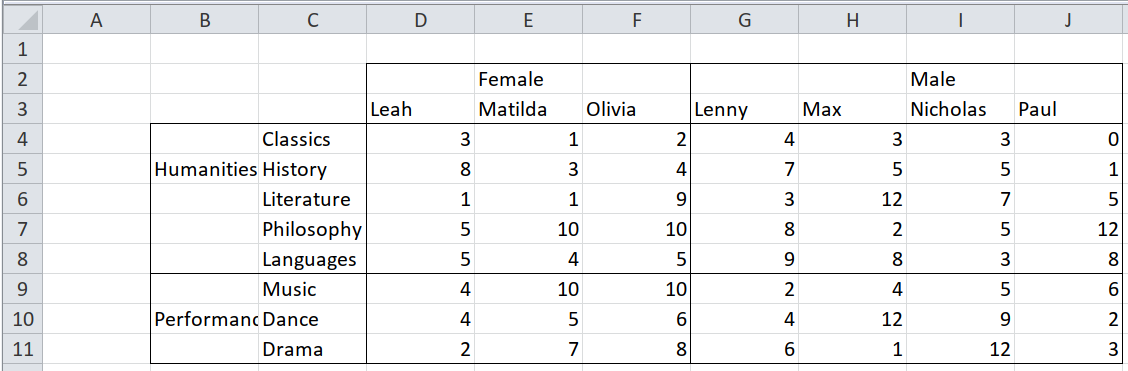

In this case, the headers are not aligned completely with the subjects or names. If the data is read into Pandas, columns B and C are set as the index of the dataframe, and a forward/backward fill applied, "Humanities" could be wrongly assigned to "Music" or "Performance" to " Literature" ("Music" should be paired with "Performance", while "Humanities" should be paired with "Literature"). Same goes for the header columns - if rows 2 and 3 are read in as header columns, and a forward/backward fill applied,  "Female" may be wrongly assigned to "Lenny", while "Male" could be wrongly assigned to "Olivia". 

![highlight-borders.png](Images/centred_aligned_headers_borders.jpg)

The solution is to get the coordinates for the horizontal and vertical borders, and use that to correctly pair the header rows and header columns. We'll use [xlsx_cells](https://pyjanitor-devs.github.io/pyjanitor/api/io/#janitor.io.xlsx_cells) function from [pyjanitor](https://pyjanitor-devs.github.io/pyjanitor/) to get the coordinates - under the hood, it uses [openpyxl](https://openpyxl.readthedocs.io/en/stable/index.html):

In [1]:
# pip install git+https://github.com/pyjanitor-devs/pyjanitor.git
import pandas as pd
import janitor
import numpy as np
from janitor import xlsx_cells

In [2]:
excel_file = pd.ExcelFile("Data_files/worked-examples.xlsx")

In [3]:
frame = xlsx_cells(excel_file, sheetnames = 'pivot-centre-aligned', border=True, include_blank_cells = False)
frame

,value,internal_value,coordinate,row,column,data_type,is_date,number_format,border
0,Female,Female,E2,2,5,s,False,General,"{'left': {'style': None, 'color': None}, 'righ..."
1,Male,Male,I2,2,9,s,False,General,"{'left': {'style': None, 'color': None}, 'righ..."
2,Leah,Leah,D3,3,4,s,False,General,"{'left': {'style': 'thin', 'color': None}, 'ri..."
3,Matilda,Matilda,E3,3,5,s,False,General,"{'left': {'style': None, 'color': None}, 'righ..."
4,Olivia,Olivia,F3,3,6,s,False,General,"{'left': {'style': None, 'color': None}, 'righ..."
...,...,...,...,...,...,...,...,...,...
70,8,8,F11,11,6,n,False,General,"{'left': {'style': None, 'color': None}, 'righ..."
71,6,6,G11,11,7,n,False,General,"{'left': {'style': 'thin', 'color': None}, 'ri..."
72,1,1,H11,11,8,n,False,General,"{'left': {'style': None, 'color': None}, 'righ..."
73,12,12,I11,11,9,n,False,General,"{'left': {'style': None, 'color': None}, 'righ..."


You can view a single row in the border column:

In [4]:
frame.border[0]

{'left': {'style': None, 'color': None},
 'right': {'style': None, 'color': None},
 'top': {'style': 'thin', 'color': None},
 'bottom': {'style': None, 'color': None},
 'diagonal': {'style': None, 'color': None},
 'vertical': None,
 'horizontal': None,
 'diagonal_direction': None,
 'diagonalUp': False,
 'diagonalDown': False,
 'outline': True,
 'start': None,
 'end': None}

The `fields` and `subjects` columns are in columns 2 and 3 respectively, the `gender` and `students` columns are in rows 2 and 3 respectively; the relevant borders top and left respectively. 

Once we have the relevant border coordinates, we can correctly link the `fields` and `subjects`, as well as the `gender` and `students` columns:

In [5]:
frame['gender'] = frame.border.str.get('left').str.get('style')
frame['fields'] = frame.border.str.get('top').str.get('style')


In [6]:
# the border is above the relevant sections, use that to our advantage to pull the relevant data
index = (frame
        .loc[frame.column.isin([2,3]), ['value', 'row', 'column', 'fields']]
        .assign(fields = lambda df: np.where(df.column.eq(2) & df.fields.isna(), df.value, df.fields))
        # pyjanitor ... syntactic sugar for pd.Series.ffill
        .fill_direction(fields = 'down')
        .replace({'thin':None})
        .fill_direction(fields = 'up')
        .query("value != fields")
        .rename(columns = {'value':'subjects'})
        )
index

,subjects,row,column,fields
9,Classics,4,3,Humanities
18,History,5,3,Humanities
26,Literature,6,3,Humanities
34,Philosophy,7,3,Humanities
42,Languages,8,3,Humanities
50,Music,9,3,Performance
59,Dance,10,3,Performance
67,Drama,11,3,Performance


Same idea used for the index is applied to the columns:

In [7]:
columns = (frame
        .loc[frame.row.isin([2,3]), ['value', 'row', 'column', 'gender']]
        # sorting ensures the right order
        # to allow correct reshaping
        .sort_values(['column', 'row'])
        .assign(gender = lambda df: np.where(df.row.eq(2) & df.gender.isna(), df.value, df.gender))
        .fill_direction(gender = 'down')
        .replace({'thin':None})
        .fill_direction(gender = 'up')
        .query("value != gender")
        .rename(columns = {'value':'students'})
        )
columns

,students,row,column,gender
2,Leah,3,4,Female
3,Matilda,3,5,Female
4,Olivia,3,6,Female
5,Lenny,3,7,Male
6,Max,3,8,Male
7,Nicholas,3,9,Male
8,Paul,3,10,Male


In [8]:
scores = (frame
        .loc[frame.data_type == 'n', ['value', 'row', 'column']]
        .rename(columns={'value':'scores'})
        )
scores

,scores,row,column
10,3,4,4
11,1,4,5
12,2,4,6
13,4,4,7
14,3,4,8
15,3,4,9
16,0,4,10
19,8,5,4
20,3,5,5
21,4,5,6


We can merge the dataframes into one:

In [9]:
(index
.drop(columns='column')
.merge(scores, on = 'row')
.merge(columns.drop(columns='row'), on = 'column')
.loc[:, ['students', 'gender', 'fields', 'subjects', 'scores']]
)

,students,gender,fields,subjects,scores
0,Leah,Female,Humanities,Classics,3
1,Leah,Female,Humanities,History,8
2,Leah,Female,Humanities,Literature,1
3,Leah,Female,Humanities,Philosophy,5
4,Leah,Female,Humanities,Languages,5
5,Leah,Female,Performance,Music,4
6,Leah,Female,Performance,Dance,4
7,Leah,Female,Performance,Drama,2
8,Matilda,Female,Humanities,Classics,1
9,Matilda,Female,Humanities,History,3


### **Case 2: Repeated rows/columns of headers within the table**
![pivot-repeated-headers.png](Images/pivot-repeated-headers.png)
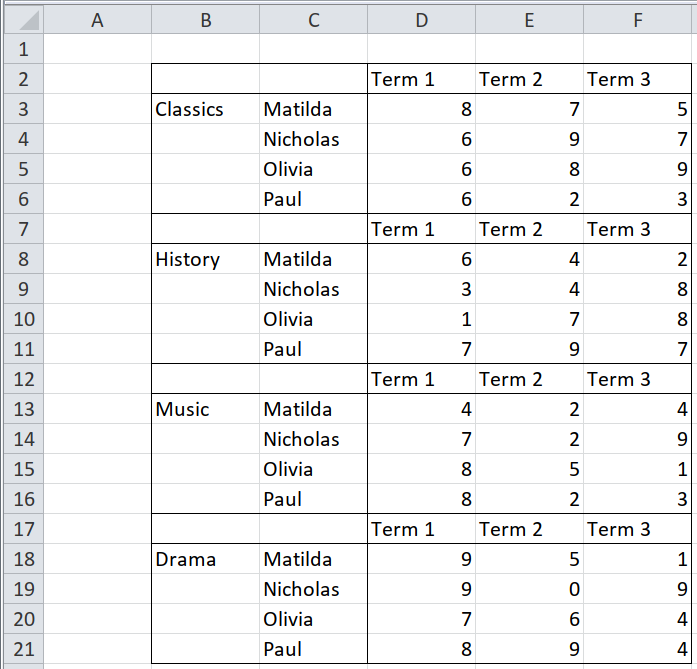

**Observations** : <br>
The row header (Term1, Term2, Term3) is repeated in four locations; we only need one.<br>
The index columns are clearly delineated; the pairing of subjects and names is assured. 

For this, we can use Pandas' directly, and take advantage of MultiIndexes:

In [10]:
(excel_file
.parse(sheet_name= "pivot-repeated-headers", header=[0, 1], index_col=[0,1,2])
.droplevel(axis = 0, level = 0)
.droplevel(axis = 1, level = 0)
.query("`Term 1` != 'Term 1'")
.rename_axis(index = ['subject', 'name'])
.melt(var_name = 'Term', value_name = 'scores', ignore_index = False)
.reset_index()
.fill_direction(subject = 'down')
)

,subject,name,Term,scores
0,Classics,Matilda,Term 1,1
1,Classics,Nicholas,Term 1,2
2,Classics,Olivia,Term 1,8
3,Classics,Paul,Term 1,9
4,History,Matilda,Term 1,6
5,History,Nicholas,Term 1,2
6,History,Olivia,Term 1,5
7,History,Paul,Term 1,2
8,Music,Matilda,Term 1,0
9,Music,Nicholas,Term 1,1


### **Case 3 : Headers amongst the data**
![pivot-header-within-data.png](Images/pivot-header-within-data.png)
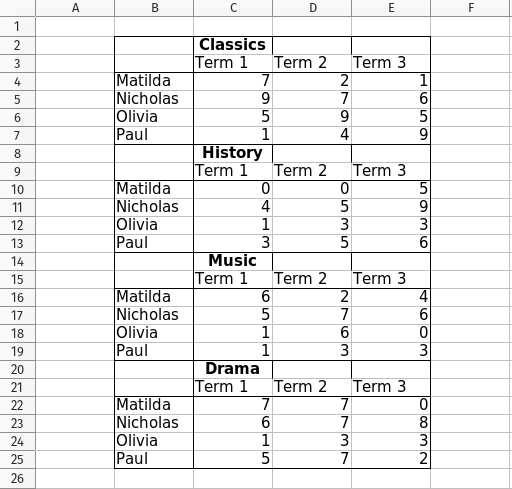

In this scenario, we have the subjects as a row header, mixed with the data. Note that the Term1,Term2,Term3 row is repeated.

 Just like in case 1, we can use [xlsx_cells](https://pyjanitor-devs.github.io/pyjanitor/api/io/#janitor.io.xlsx_cells) to get the font data (specifically, the cells with bold font) and with that location, correctly align the data:

In [11]:
frame = xlsx_cells(excel_file, sheetnames="pivot-header-within-data", font=True, include_blank_cells=False)
frame['bold'] = frame.font.str.get('b')
frame

,value,internal_value,coordinate,row,column,data_type,is_date,number_format,font,bold
0,Classics,Classics,C2,2,3,s,False,General,"{'name': 'Calibri', 'family': 2.0, 'sz': 11.0,...",True
1,Term 1,Term 1,C3,3,3,s,False,General,"{'name': 'Calibri', 'family': 2.0, 'sz': 11.0,...",False
2,Term 2,Term 2,D3,3,4,s,False,General,"{'name': 'Calibri', 'family': 2.0, 'sz': 11.0,...",False
3,Term 3,Term 3,E3,3,5,s,False,General,"{'name': 'Calibri', 'family': 2.0, 'sz': 11.0,...",False
4,Matilda,Matilda,B4,4,2,s,False,General,"{'name': 'Calibri', 'family': 2.0, 'sz': 11.0,...",False
...,...,...,...,...,...,...,...,...,...,...
75,3,3,E24,24,5,n,False,General,"{'name': 'Calibri', 'family': 2.0, 'sz': 11.0,...",False
76,Paul,Paul,B25,25,2,s,False,General,"{'name': 'Calibri', 'family': 2.0, 'sz': 11.0,...",False
77,5,5,C25,25,3,n,False,General,"{'name': 'Calibri', 'family': 2.0, 'sz': 11.0,...",False
78,7,7,D25,25,4,n,False,General,"{'name': 'Calibri', 'family': 2.0, 'sz': 11.0,...",False


In [12]:
name_subject = (frame
                .loc[frame.data_type.eq('s') & ~frame.value.str.startswith('Term', na = False), ['value', 'bold', 'row', 'column']]
                .assign(subject = lambda df: np.where(df.bold, df.value, np.nan))
                .fill_direction(subject = 'down')
                .query('value != subject')
                .rename(columns={'value':'name'})
                .drop(columns = 'bold')
                )

name_subject

,name,row,column,subject
4,Matilda,4,2,Classics
8,Nicholas,5,2,Classics
12,Olivia,6,2,Classics
16,Paul,7,2,Classics
24,Matilda,10,2,History
28,Nicholas,11,2,History
32,Olivia,12,2,History
36,Paul,13,2,History
44,Matilda,16,2,Music
48,Nicholas,17,2,Music


Get the terms:

In [13]:
terms = (frame
        .loc[frame.value.str.startswith('Term', na = False), ['value', 'column']]
        .drop_duplicates()
        .rename(columns={'value':'term'})
        )
terms

,term,column
1,Term 1,3
2,Term 2,4
3,Term 3,5


In [14]:
scores = (frame
        .loc[frame.data_type == 'n', ['value', 'row', 'column']]
        .rename(columns={'value':'scores'})
        )
scores

,scores,row,column
5,7,4,3
6,2,4,4
7,1,4,5
9,9,5,3
10,7,5,4
11,6,5,5
13,5,6,3
14,9,6,4
15,5,6,5
17,1,7,3


Merge the dataframes into one:

In [15]:
(name_subject
.drop(columns='column')
.merge(scores, on = 'row')
.merge(terms, on = 'column')
.drop(columns = ['row', 'column'])
)

,name,subject,scores,term
0,Matilda,Classics,7,Term 1
1,Nicholas,Classics,9,Term 1
2,Olivia,Classics,5,Term 1
3,Paul,Classics,1,Term 1
4,Matilda,History,0,Term 1
5,Nicholas,History,4,Term 1
6,Olivia,History,1,Term 1
7,Paul,History,3,Term 1
8,Matilda,Music,6,Term 1
9,Nicholas,Music,5,Term 1
